# **Importing Packages**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.stats.mstats import normaltest # D'Agostino K^2 Test
from scipy.stats import boxcox

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

#Evaluation Metric
from sklearn.metrics import r2_score  # how well we are explaining our variants wrt regression
from sklearn.metrics import cohen_kappa_score  
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, PolynomialFeatures
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import mlxtend
import joblib
import pickle
import sys
from google.colab import files
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector as SFS   #Forward Feature Selection

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# **Model Tracking**

In [ ]:
log_df = pd.DataFrame(columns = ['modelName', 'features_list', 'features_size', 'hyperparameters', 'scaling_type', 'no_of_kfolds','comments','r2-score', 'mae','cohen_kappa_score'])

In [ ]:
class Logger_Regression:
    modelName = "",      # linearRegression,lasso,ridge, SVR 
    features_list = list(),
    features_size = 0,
    hyperparameters = "none",  #alpha_value, max_iteration
    scaling_type = "none",    #standard, minmax, maxabs
    no_of_kfolds = 0,
    comments = "",
    r2_score = 0,
    mae = 0,
    cohen_kappa_score = 0

    def  __init__(self, modelName, feature_list, features_size):
      self.modelName = modelName
      self.features_list = feature_list
      self.features_size = features_size

    ############################ Linear Regression ###############################
    def linearRegression_basic(self,X,y):
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=72018)
      lr = LinearRegression()
      lr.fit(X_train, y_train)
      y_pred = lr.predict(X_test)
      #print(y_pred[:10])
      #print(y_test[:10])
      self.r2_score = r2_score(y_test,y_pred)*100
      self.mae = mean_absolute_error(y_test,y_pred)
      self.cohen_kappa_score=cohen_kappa_score(np.floor(y_pred), np.floor(y_test.values),weights="quadratic")
      self.add_log()

    def linearRegression_scaling(self,X,y,no_of_kfolds):
      kf = KFold(shuffle=True, random_state=72018, n_splits=no_of_kfolds)
      self.no_of_kfolds = no_of_kfolds
      scalers = {'standard': StandardScaler(),
                  'minmax': MinMaxScaler(),
                  'maxabs': MaxAbsScaler()}
        
      for scaler_label, scaler in scalers.items():
         s = scaler
         self.scaling_type = scaler_label
         lr = LinearRegression()
         estimator = Pipeline([("scaler", s), ("regression", lr)])
         predictions = cross_val_predict(estimator, X, y, cv=kf)
         self.mae = mean_absolute_error(y,predictions)
         self.r2_score = r2_score(y, predictions)*100
         self.cohen_kappa_score=cohen_kappa_score(np.rint(predictions), np.rint(y),weights="quadratic")
         self.add_log()
    
    ######################################## Lasso Regression #############################################
    def lasso_regression(self,X,y,polydegree,alphaValue):
      kf = KFold(shuffle=True, random_state=72018, n_splits=3)
      s= StandardScaler()  #since all scaling types were yielding same results
      self.scaling_type = "StandardScaler()"
      las = Lasso(alpha=alphaValue,  max_iter=10000000)
      estimator = Pipeline([
        ("polynomial_features", PolynomialFeatures(degree = polydegree)),
        ("scaler", s),
        ("lasso_regression", las)])
      predictions = cross_val_predict(estimator, X, y, cv=kf)
      self.r2_score = r2_score(y, predictions)*100
      self.mae = mean_absolute_error(y,predictions)
      self.cohen_kappa_score=cohen_kappa_score(np.rint(predictions), np.rint(y),weights="quadratic")
      self.add_log()
      return las
   
    ####################################### GridSearchCV ###############################################
    def gridSearchCV(self,X,y,modelName):
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=72018)
      if modelName == 'Ridge':
        labeler = "ridge_regression"
        model = Ridge()
      elif modelName == 'Lasso':
        labeler = "lasso_regression"
        model = Lasso()

      estimator = Pipeline([
        ("polynomial_features", PolynomialFeatures()),
        (labeler, model)])
      # The name of paramas should be similar to that mentioned in estimators, ending with two underscores and param name.
      params = {
        'polynomial_features__degree': [1, 2, 3],
         #labeler+'__alpha': np.geomspace(4, 20, 30)
         labeler+'__alpha' : np.geomspace(1e-9, 1e0, num=10)
        }
      kf = KFold(shuffle=True, random_state=72018, n_splits=3)  
      self.no_of_kfolds =3
      grid = GridSearchCV(estimator, params, cv=kf)
      grid.fit(X_train, y_train)
      predictions = grid.predict(X_test)
      print("gridCBV best scores: " ,grid.best_score_)
      self.hyperparameters= grid.best_params_
      self.r2_score = r2_score(y_test, predictions)*100
      self.cohen_kappa_score=cohen_kappa_score(np.rint(predictions), np.rint(y_test),weights="quadratic")
      self.mae = mean_absolute_error(y_test,predictions)
      self.add_log()

    ################################# SVR ###################################################
    def svr_gridSearchCV(self,X,y):
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=72018)
      svr = SVR()
      parameters = {'kernel':['linear', 'rbf'], 'C':[1,100], 'gamma':[0.1, 0.001]}
      #parameters = {'kernel':['linear', 'rbf'], 'C':[2**-5, 2], 'gamma':[0.1, 0.001]} --Research Paper
      grid = GridSearchCV(svr, parameters)
      grid.fit(X_train, y_train)
      y_pred = grid.predict(X_test)
      # summarize the results of the grid search
      print(grid.best_score_)
      print(grid.best_estimator_)
      self.cohen_kappa_score = cohen_kappa_score(np.rint(y_pred), np.rint(y_test),weights="quadratic")
      self.r2_score = r2_score(y_test, y_pred)*100
      self.mae = mean_absolute_error(y_test,y_pred)

    ################################### Random Forest ###########################################
    def randomforest_regressor(self,X,y):
       X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=72018)
       rf = RandomForestRegressor(n_estimators = 100, oob_score = True, n_jobs = -1,random_state =50, max_features = "auto", min_samples_leaf = 50)
       rf.fit(X_train, y_train)
       y_pred = rf.predict(X_test)
       self.r2_score = r2_score(y_test,y_pred)*100
       self.mae = mean_absolute_error(y_test,y_pred)
       self.cohen_kappa_score=cohen_kappa_score(np.rint(y_pred), np.rint(y_test.values),weights="quadratic")
       #print("cofficeint of determination: ", rf.score())
       self.add_log()
       return rf
    
    ################################# Gradient Boosting Regressor Basic #####################################
    def gbr_basic(self, X, y, learningRate=0.01, nEstimator=500, subSample=0.5 ):
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=72018)
      gbr = ensemble.GradientBoostingRegressor(learning_rate= learningRate, n_estimators= nEstimator, subsample= subSample)
      gbr.fit(X_train, y_train)
      y_pred = gbr.predict(X_test)
      self.hyperparamters = dict(learning_rate= learningRate, n_estimators= nEstimator, subsample= subSample)
      self.r2_score = r2_score(y_test,y_pred)*100
      self.mae = mean_absolute_error(y_test,y_pred)
      self.cohen_kappa_score=cohen_kappa_score(np.rint(y_pred), np.rint(y_test.values),weights="quadratic")
      self.add_log()
      return gbr

    ################################## Gradient Boosting Regressor GridSearchCV ###############################
    def gradientBoostingRegressor(self,X,y):
      X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=72018)
      grid = dict()
      grid['n_estimators'] = [10, 50, 100, 500]
      grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
      grid['subsample'] = [0.5, 0.7, 1.0]
      grid['max_depth'] = [3, 7, 9]
      gbr = ensemble.GradientBoostingRegressor()
      cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
      model = GridSearchCV(estimator=gbr, param_grid=grid, n_jobs=-1, cv=cv)
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
      # summarize the results of the grid search
      print(model.best_score_)
      self.hyperparameters = model.best_estimator_
      print(model.best_estimator_)
      mae = mean_absolute_error(y_test, y_pred)
      mse = mean_squared_error(y_test, y_pred)
      print("Mean Absolute Error:", mae)
      print("")
      self.r2_score = r2_score(y_test,y_pred)*100
      self.mae = mean_absolute_error(y_test,y_pred)
      self.cohen_kappa_score=cohen_kappa_score(np.rint(y_pred), np.rint(y_test.values),weights="quadratic")
      self.add_log()

    def set_comment(self,message):
      self.comments = message
    
    def add_log(self):
      print("Mean Absolute Error of "+ self.comments +"  %.3f " %self.mae)
      print("R2 score of " + self.comments + " :%.3f" %self.r2_score)
      print("Cohen Kappa score "+ self.comments +" : %.3f" %self.cohen_kappa_score)
      row = [self.modelName, self.features_list, self.features_size, self.hyperparameters, self.scaling_type, self.no_of_kfolds, self.comments ,self.r2_score, self.mae, self.cohen_kappa_score]
      log_df.loc[len(log_df)] = row

# **Approach01: Traditional Features**

### **Filtering DataFrame**


Mounting Data From Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df_train = pd.read_csv("/content/drive/My Drive/IntelliTech-DataSet/Features/EssaySet04_Features.csv", index_col =0)
df_train.head()

Dropping Null Values (if any)

In [ ]:
df_train.drop(df_train[df_train["Total Score"].isna() == True].index , axis = 0 , inplace = True )

In [ ]:
df_train.columns

Selecting features from DataFrame

In [ ]:
feats = ['Total Score', 'Sent_Count', 'Word_Count', 'Char_Count',
       'Avg_Word_Count', 'Avg_Sentence_Length', 'Syllable_Count', 'Difficult_Word_Count', 'Verb_Count', 'Noun_Count',
       'Adj_Count', 'Conj_Count', 'Adverb_Count', 'pNoun_Count',
       'Spelling_Mistakes_Count','Count_Fullstops', 'Count_Exclamation',
       'Count_Comma', 'Count_Questionmark', 'Count_Hyphens',
       'Capitalization_Errors', 'Grammar_Error_Count', 'Semantic_Similarity', 'Connectivity_Index',
       'Flesch_Reading_Ease_Score', 'Flesh_Kincaid_Grade',
       'Dale_Challl_Readability_Score', 'Unique_Words_LD', 'Lexical_Diversity',
       'Lexical_Density', 'Lexical_Originality', 'Lexical_Accuracy']
df_train = df_train.loc[:, df_train.columns.isin(feats)]

In [ ]:
df_train.head()

,Total Score,Sent_Count,Word_Count,Char_Count,Avg_Word_Count,Avg_Sentence_Length,Syllable_Count,Difficult_Word_Count,Verb_Count,Noun_Count,...,Semantic_Similarity,Connectivity_Index,Flesch_Reading_Ease_Score,Flesh_Kincaid_Grade,Dale_Challl_Readability_Score,Unique_Words_LD,Lexical_Diversity,Lexical_Density,Lexical_Originality,Lexical_Accuracy
0,0.0,3,64,308,3.875000,21.333333,79,10,10,10,...,0.521394,5.563429,80.753542,4.239494,7.161821,43,0.671875,34,0.000231,0
1,0.0,2,40,210,4.225000,20.000000,50,5,8,8,...,0.335533,1.846574,80.785000,3.600000,6.602250,23,0.575000,27,0.000123,4
2,3.0,5,150,792,4.380000,30.000000,198,24,12,40,...,0.628615,9.944323,64.713000,8.793394,7.650900,60,0.400000,78,0.000322,0
3,2.0,6,71,379,4.436620,11.833333,93,15,10,14,...,0.139402,3.959785,84.010082,-0.536398,7.559349,46,0.647887,41,0.000247,0
4,2.0,9,144,705,4.013889,16.000000,164,22,15,22,...,0.233307,6.212712,94.245000,1.877642,6.842461,63,0.437500,70,0.000338,1


In [ ]:
df_train.shape

(1771, 32)

### **Data Visualizations**

#### **Histogram**

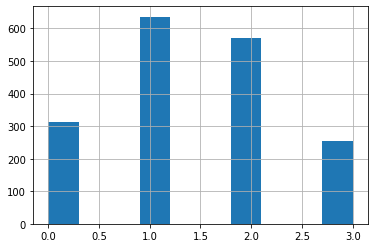

In [ ]:
df_train['Total Score'].hist()

#### **Box Plot**
This is essentially done to visualize the outliers in the target score. This step will tell us if we need to scale our values or not.

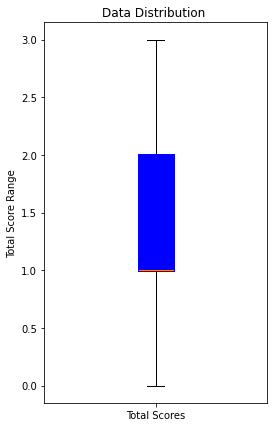

In [ ]:
plt.figure(figsize =(4,7))   #Vertical box-plots gives good visualization
plt.style.use("default")
boxes = plt.boxplot(df_train['Total Score'], labels= ['Total Scores'], patch_artist = True)
plt.title("Data Distribution ")
plt.ylabel("Total Score Range")
for box in boxes['boxes']:
    box.set(color = "blue", linewidth= 3, hatch= '/', facecolor= "orange")
plt.show()

In [ ]:
df_train['Total Score'].describe()   #Range of total score for essayset01 is 2-12, and histogram shows majority has scored between above 8.

count    1771.000000
mean        1.431395
std         0.940133
min         0.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         3.000000
Name: Total Score, dtype: float64

### **Performing Normalization Test**


*   This test outputs a "p-value". The higher this p-value is  the closer the distribution is to normal.
*   If the p-value > 0.05, then it is bell-curve distribution.





### **Transforming Target for Normal Distribution**
1. Log Test
2. Square Root
3. Box Cox

Apply transformations to make target variable more normally distributed for regression.

In [ ]:
normaltest(df_train['Total Score'].values)

NormaltestResult(statistic=221.11317797480612, pvalue=9.680180708088265e-49)

#### **1. Log Test**

In [ ]:
log_scores = np.log(df_train['Total Score'])
log_scores.hist();

In [ ]:
log_scores

0       2.079442
1       2.197225
2       1.945910
3       2.302585
4       2.079442
          ...   
1778    2.079442
1779    1.945910
1780    2.079442
1781    0.693147
1782    1.945910
Name: Total Score, Length: 1783, dtype: float64

In [ ]:
normaltest(log_scores)   

NormaltestResult(statistic=967.9747627089553, pvalue=6.411371863278859e-211)

#### **2. Square Root Transformation**

(array([ 10.,   1.,  17.,   0.,  17., 110., 822., 334., 316., 156.]),
 array([1.41421356, 1.61920237, 1.82419117, 2.02917998, 2.23416878,
        2.43915759, 2.64414639, 2.8491352 , 3.054124  , 3.25911281,
        3.46410162]),
 <a list of 10 Patch objects>)

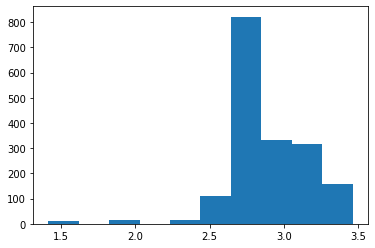

In [ ]:
sqrt_scores = np.sqrt(df_train['Total Score'])
plt.hist(sqrt_scores)

In [ ]:
normaltest(sqrt_scores)

NormaltestResult(statistic=456.280616698139, pvalue=8.316162831695822e-100)

#### **3. BoxCox**



In [ ]:
bc_result = boxcox(df_train['Total Score'])
boxcox_score = bc_result[0]
lam = bc_result[1]
lam

In [ ]:
boxcox_score.shape

(1783,)

In [ ]:
df_train['Total Score'].hist();

In [ ]:
normaltest(boxcox_score)

NormaltestResult(statistic=17.904988751361316, pvalue=0.00012941395009995448)

Significantly more normally distributed (according to p value) than the other two distributions

## **Models**

### **Linear Regression Model**


In [ ]:
#basic model
y_col = "Total Score"
X = df_train.drop(y_col, axis=1)
y = df_train[y_col]
data_logger = Logger_Regression("Linear Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Vanilla Linear Regression Model")
data_logger.linearRegression_basic(X,y)

Mean Absolute Error of Vanilla Linear Regression Model  0.502 
R2 score of Vanilla Linear Regression Model :52.581
Cohen Kappa score Vanilla Linear Regression Model : 0.561


In [ ]:
# #boxcox variation
# data_logger = Logger_Regression("Linear Regression", list(X.columns), len(list(X.columns)))
# data_logger.set_comment("Vanilla Linear Regression Model with Boxcox variation")
# #data_logger.linearRegression_basic(X,pd.Series(boxcox_score))

In [ ]:
#scaling with no transformation
data_logger = Logger_Regression("Linear Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Vanilla Linear Regression Model with Scaling")
data_logger.linearRegression_scaling(X,y,3)

Mean Absolute Error of Vanilla Linear Regression Model with Scaling  0.484 
R2 score of Vanilla Linear Regression Model with Scaling :56.946
Cohen Kappa score Vanilla Linear Regression Model with Scaling : 0.675
Mean Absolute Error of Vanilla Linear Regression Model with Scaling  0.484 
R2 score of Vanilla Linear Regression Model with Scaling :56.946
Cohen Kappa score Vanilla Linear Regression Model with Scaling : 0.675
Mean Absolute Error of Vanilla Linear Regression Model with Scaling  0.484 
R2 score of Vanilla Linear Regression Model with Scaling :56.946
Cohen Kappa score Vanilla Linear Regression Model with Scaling : 0.675


In [ ]:
# #scaling with target transformation
# data_logger = Logger_Regression("Linear Regression", list(X.columns), len(list(X.columns)))
# data_logger.set_comment("Vanilla Linear Regression Model with Scaling on Boxcox Target")
# data_logger.linearRegression_scaling(X,boxcox_score,3)

### **GridSearchCV (Lasso and Ridge Regression)**

`
Execution Time: 2 minutes
`

In [ ]:
data_logger = Logger_Regression("Lasso Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Lasso Regression + GridSearchCV")
data_logger.gridSearchCV(X,y,"Lasso")

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.422e+02, tolerance: 7.370e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.449e+02, tolerance: 7.259e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.325e+02, tolerance: 7.443e-02

gridCBV best scores:  0.591847794773565
Mean Absolute Error of Lasso Regression + GridSearchCV  0.506 
R2 score of Lasso Regression + GridSearchCV :52.366
Cohen Kappa score Lasso Regression + GridSearchCV : 0.661


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.330e+01, tolerance: 7.443e-02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.319e-01, tolerance: 1.104e-01
  model = cd_fast.enet_coordinate_descent(


Note: Only For Essay Set 01 and 02

### **Ridge Regression**

In [ ]:
data_logger = Logger_Regression("Ridge Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Ridge regression +GridSearchCV")
data_logger.gridSearchCV(X,boxcox_score,"Ridge")

Execution Time: 15 mins+

In [ ]:
# Training on Best Parameters
data_logger = Logger_Regression("Lasso Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Lasso Regression on Best Parameters")
data_logger.lasso_regression(X,y,1,0.0000001)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.753e+02, tolerance: 1.047e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.694e+02, tolerance: 1.046e-01
  model = cd_fast.enet_coordinate_descent(


Mean Absolute Error of Lasso Regression on Best Parameters  0.484 
R2 score of Lasso Regression on Best Parameters :56.795
Cohen Kappa score Lasso Regression on Best Parameters : 0.681


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.868e+02, tolerance: 1.036e-01
  model = cd_fast.enet_coordinate_descent(


Lasso(alpha=1e-07, max_iter=10000000)

### **Random Forest Regressor**

In [ ]:
#Basic Model
y_col = "Total Score"
X = df_train.drop(y_col, axis=1)
y = df_train[y_col]
data_logger = Logger_Regression("Random Forest Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Random Forest Regressor Model")
data_logger.randomforest_regressor(X,y)

Mean Absolute Error of Random Forest Regressor Model  0.488 
R2 score of Random Forest Regressor Model :55.831
Cohen Kappa score Random Forest Regressor Model : 0.677


RandomForestRegressor(min_samples_leaf=50, n_jobs=-1, oob_score=True,
                      random_state=50)

### **Gradient Boosting Algorithm**

`
Execution Time: 1 Hour 45 Minutes +
`

In [ ]:
#GridSearchCV
y_col = "Total Score"
X = df_train.drop(y_col, axis=1)
y = df_train[y_col]
data_logger = Logger_Regression("Gradient Boosting Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Gradient Boosting Model")
data_logger.gradientBoostingRegressor(X,y)

0.5994312942301279
GradientBoostingRegressor(learning_rate=0.01, n_estimators=500, subsample=0.7)
Mean Absolute Error: 0.48986545283803934

Mean Absolute Error of Gradient Boosting Model  0.490 
R2 score of Gradient Boosting Model :55.533
Cohen Kappa score Gradient Boosting Model : 0.654


## **Forward Feature Selection**

### **Features Correlation**

#### Pearson Correlation

Text(0.5, 1.0, 'Pearson Correlation')

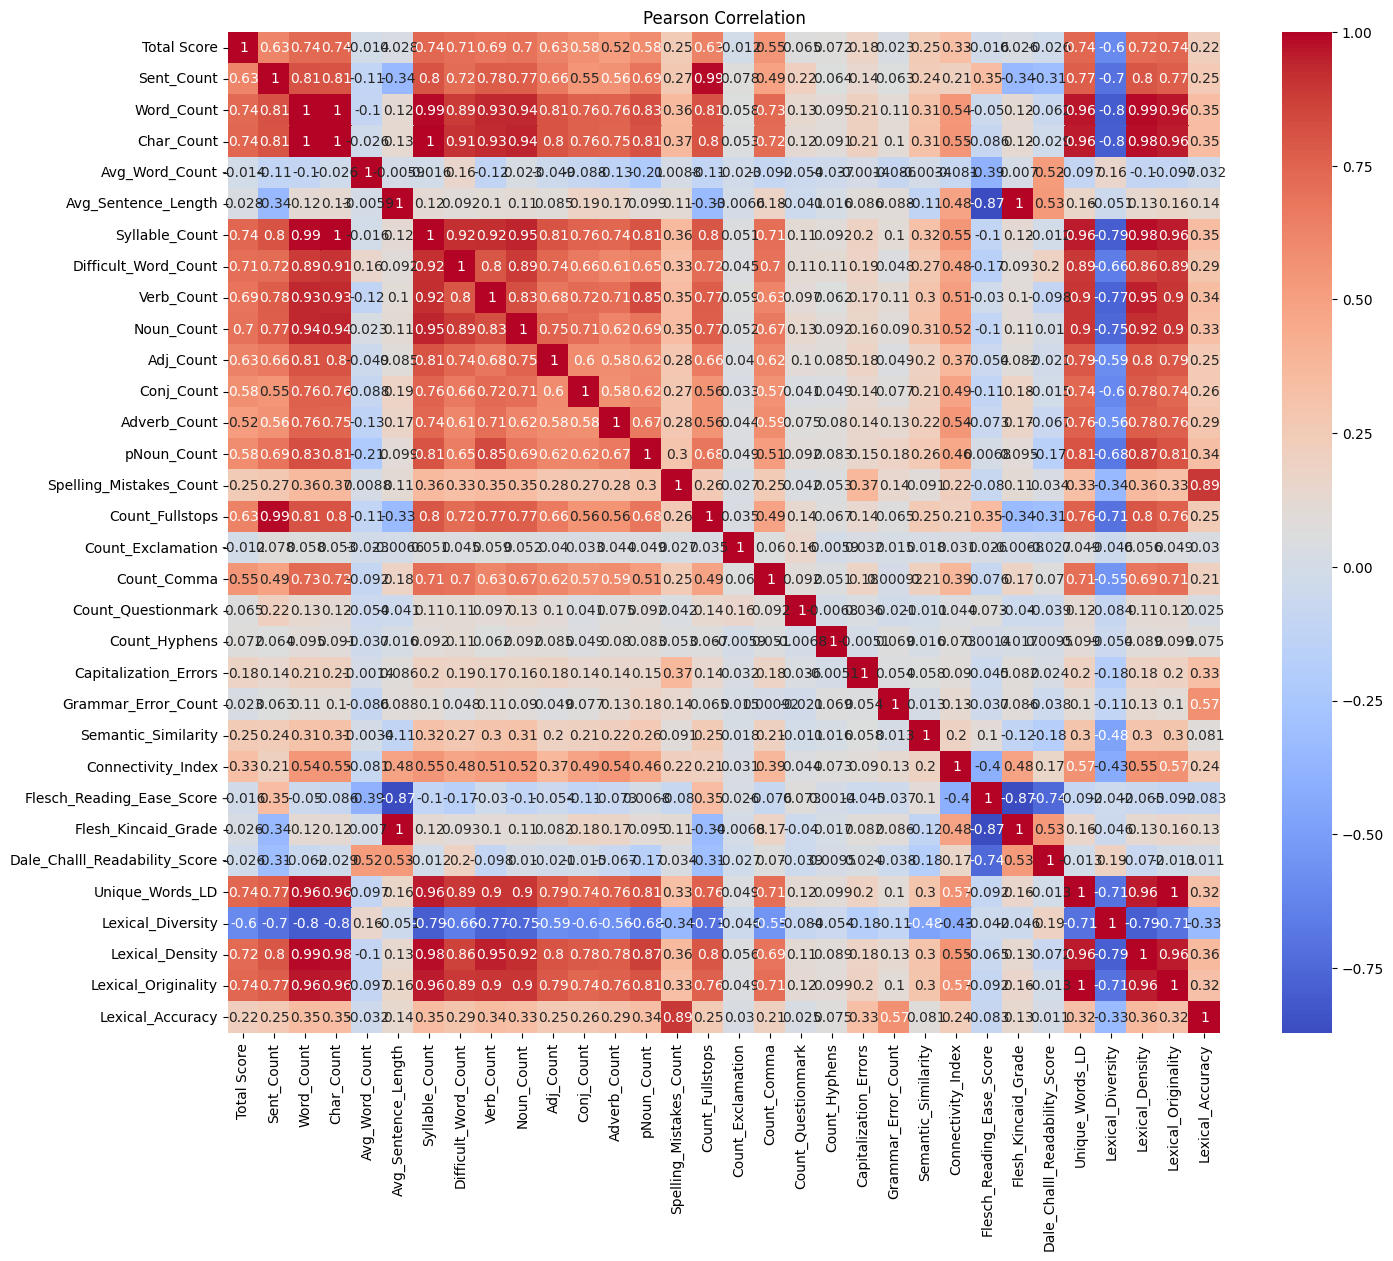

In [ ]:
correlation_pearson = df_train.corr()
plt.figure(figsize=(16,13))
sns.heatmap(correlation_pearson,annot=True, cmap="coolwarm").set_title('Pearson Correlation')

#### Spearmen's Correlation 

Text(0.5, 1.0, 'Spearmens Correlation')

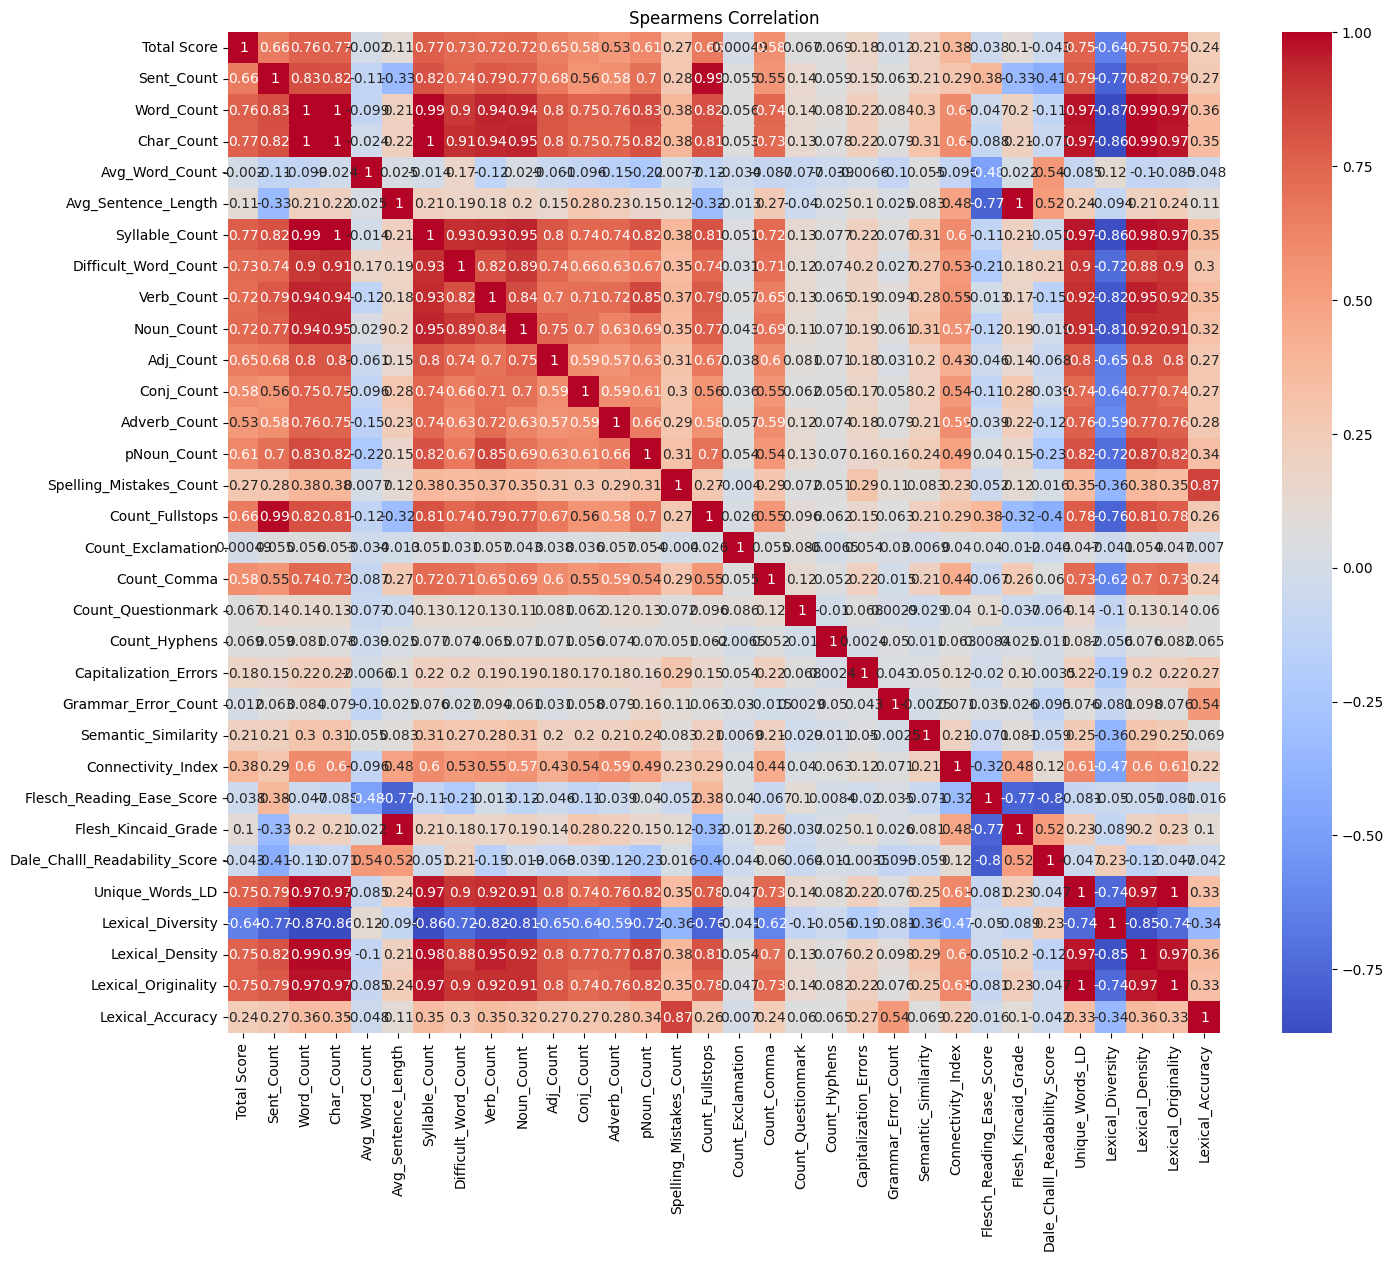

In [ ]:
#The deafult method of correlation is 'Pearson' which is used when linear relationship between variables are gauranteed.
#Pearson is sensitive to outliers
correlation_spear = df_train.corr(method='spearman')
plt.figure(figsize=(16,13))
sns.heatmap(correlation_spear, annot=True, cmap="coolwarm").set_title('Spearmens Correlation')

### **Removing Constant and Correlated Features**

#### **Removing Constant Features**


In [ ]:
y_col = "Total Score"
X = df_train.drop(y_col, axis=1)
constant_features = [ feat for feat in X.columns if X[feat].std() == 0]
print(constant_features)

df_train.drop(labels=constant_features, axis=1, inplace=True)

[]


#### **Removing Correlated Features**

In [ ]:
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr(method='spearman')
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

y_col = "Total Score"
X = df_train.drop(y_col, axis=1)
corr_features = correlation(X, 0.8)
print(corr_features)
print('correlated features: ', len(set(corr_features)))
df_train.drop(labels=corr_features, axis=1, inplace=True)

{'Difficult_Word_Count', 'Lexical_Accuracy', 'Count_Fullstops', 'Flesh_Kincaid_Grade', 'Word_Count', 'Char_Count', 'pNoun_Count', 'Unique_Words_LD', 'Verb_Count', 'Lexical_Density', 'Noun_Count', 'Lexical_Diversity', 'Lexical_Originality', 'Syllable_Count'}
correlated features:  14


### **Training with Forward Feature Selection**

We begin with a model that has no predictors, then we fit a model for each possible predictor, identifying the model where the corresponding predictor’s p-value is smallest. If that p-value is smaller than α = 0.05, we add it to the model and repeat the process, considering whether to add more variables one-at-a-time. When none of the remaining predictors can be added to the model and have a p-value less than 0.05, then we stop adding variables and the current model would be our best-fitting model.

**⏳Optional**: Remove correlated, quasi-constant features, OLS Regression, Interpreting features from rubrics and establish strong reasoning for the results.


#### **Linear Regression**

In [ ]:
def forwardFeatureSelection(i):
  y_col = "Total Score"
  X = df_train.drop(y_col, axis=1)
  y = df_train[y_col]
  sfs = SFS(LinearRegression(),
              k_features=i,   
              forward=True,
              floating=False,
              scoring = 'r2',
              cv = 0)
  sfs.fit(np.array(X), y)
  print("Selected Features: " ,X.columns[list(sfs.k_feature_idx_)])
  X_ = sfs.transform(X)
  X_1 = pd.DataFrame(X_.tolist())
  #X_1.shape
  return X.columns[list(sfs.k_feature_idx_)],X_1

In [ ]:
y_col = "Total Score"
X = df_train.drop(y_col, axis=1)
y = df_train[y_col]

for i in range(5,len(X.columns)):
  selected_cols,transformed_X = forwardFeatureSelection(i)
  data_logger = Logger_Regression("Linear Regression", selected_cols, len(selected_cols))
  data_logger.set_comment("Vanilla Linear Regression Model with SFS")
  data_logger.linearRegression_basic(transformed_X,y)

Selected Features:  Index(['Sent_Count', 'Adj_Count', 'Conj_Count', 'Count_Comma',
       'Flesch_Reading_Ease_Score'],
      dtype='object')
Mean Absolute Error of Vanilla Linear Regression Model with SFS  0.512 
R2 score of Vanilla Linear Regression Model with SFS :48.944
Cohen Kappa score Vanilla Linear Regression Model with SFS : 0.510
Selected Features:  Index(['Sent_Count', 'Adj_Count', 'Conj_Count', 'Count_Comma',
       'Semantic_Similarity', 'Flesch_Reading_Ease_Score'],
      dtype='object')
Mean Absolute Error of Vanilla Linear Regression Model with SFS  0.508 
R2 score of Vanilla Linear Regression Model with SFS :49.586
Cohen Kappa score Vanilla Linear Regression Model with SFS : 0.526
Selected Features:  Index(['Sent_Count', 'Adj_Count', 'Conj_Count', 'Count_Exclamation',
       'Count_Comma', 'Semantic_Similarity', 'Flesch_Reading_Ease_Score'],
      dtype='object')
Mean Absolute Error of Vanilla Linear Regression Model with SFS  0.506 
R2 score of Vanilla Linear Regressi

#### **Random Forest Regressor**

`
Execution Time: 7 mins
`


In [ ]:
def forwardFeatureSelection_RF(i):
  y_col = "Total Score"
  X = df_train.drop(y_col, axis=1)
  y = df_train[y_col]
  sfs = SFS(RandomForestRegressor(n_estimators = 100, oob_score = True, n_jobs = -1,random_state =50, max_features = "auto", min_samples_leaf = 50),
              k_features=i,   
              forward=True,
              floating=False,
              scoring = 'r2',
              cv = 0)
  sfs.fit(np.array(X), y)
  print("Selected Features: " ,X.columns[list(sfs.k_feature_idx_)])
  X_ = sfs.transform(X)
  X_1 = pd.DataFrame(X_.tolist())
  
  return X.columns[list(sfs.k_feature_idx_)],X_1

In [ ]:
y_col = "Total Score"
X = df_train.drop(y_col, axis=1)
y = df_train[y_col]

for i in range(5,len(X.columns)):
  selected_cols,transformed_X = forwardFeatureSelection_RF(i)
  data_logger = Logger_Regression("RF Regression", selected_cols, len(selected_cols))
  data_logger.set_comment("RF Regression Model with SFS")
  data_logger.randomforest_regressor(transformed_X,y)

#### **Gradient Boosting Regression**

`
Execution Time: 17 minutes
`

In [ ]:
def forwardFeatureSelection_GBR(i):
  y_col = "Total Score"
  X = df_train.drop(y_col, axis=1)
  y = df_train[y_col]
  # Training on best parameters
  sfs = SFS(ensemble.GradientBoostingRegressor(learning_rate=0.01, n_estimators=500, subsample=0.5),
              k_features=i,   
              forward=True,
              floating=False,
              scoring = 'r2',
              cv = 0)
  sfs.fit(np.array(X), y)
  print("Selected Features: " ,X.columns[list(sfs.k_feature_idx_)])
  X_ = sfs.transform(X)
  X_1 = pd.DataFrame(X_.tolist())

  return X.columns[list(sfs.k_feature_idx_)],X_1

In [ ]:
y_col = "Total Score"
X = df_train.drop(y_col, axis=1)
y = df_train[y_col]

for i in range(5,len(X.columns)-1):
  selected_cols,transformed_X = forwardFeatureSelection_GBR(i)
  data_logger = Logger_Regression("Gradient Boosting Regression", selected_cols, len(selected_cols))
  data_logger.set_comment("Gradient Boosting Regression Model with SFS")
  data_logger.gbr_basic(transformed_X,y)

In [ ]:
log_df.to_csv("Model_Tracking_Set01.csv")
files.download('/content/Model_Tracking_Set01.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Approach 02: Word Embedding Features via Gensim**

### **Word2Vec Features**

Mounting Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/IntelliTech-DataSet/EssaySet04.csv")
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,ID,Essay,Rater_1 Score,Rater_2 Score,Total Score
0,8863,The author concludes the story with this becau...,0.0,0.0,0.0
1,8864,The narrater has that in with Paragraph becuse...,0.0,0.0,0.0
2,8865,The author concludes the story with that passa...,3.0,2.0,3.0
3,8866,The author ended the story with this paragraph...,1.0,2.0,2.0
4,8867,The author concludes the story with this parag...,2.0,2.0,2.0


Removing Null Values (if any)

In [ ]:
df.drop(df[df["Total Score"].isna() == True].index , axis = 0 , inplace = True )

In [ ]:
df.shape

(1771, 5)

In [ ]:
# create a list of essay strings
essays = df['Essay']
essay_list = [ess for ess in essays]

# tokenize the string into words
tokens = [word_tokenize(ess) for ess in essay_list]

# Remove non-alphabetic tokens, such as punctuation
words_list = [[word.lower() for word in sentences if word.isalpha()] for sentences in tokens]

# Remove stopwords
words_list = [[word for word in sentence if not word in stop_words] for sentence in words_list]

In [ ]:
def word2vec_model(docs_list):
  model = Word2Vec(docs_list, min_count=1)
  vocab = list(model.wv.vocab.keys())
  df = pd.DataFrame([model.wv.word_vec(w) for w in vocab], index=vocab)
  print(df.shape)
  df.to_csv("word2vec_features.csv", index = True)
  return model

model = word2vec_model(words_list)

(4664, 100)


In [ ]:
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in model.wv.vocab]
    return np.mean(model[doc], axis=0)

# Our earlier preprocessing was done when we were dealing only with word vectors
# Here, we need each document to remain a document 
def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()] 
    return doc

In [ ]:
corpus = [preprocess(essay) for essay in essay_list]

In [ ]:
x = []
for doc in corpus: # append the vector for each document
    x.append(document_vector(model, doc))
    
X = np.array(x)

<ipython-input-15-db7da09bea5a>:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  return np.mean(model[doc], axis=0)


In [ ]:
df_d2v = pd.DataFrame(X)
df_d2v.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.246798,-0.238112,0.071566,-0.106149,0.042973,-0.131251,-0.500286,0.148962,0.249296,-0.437727,...,-0.254430,0.380029,0.294924,-0.815801,-0.437317,-0.121874,-0.242635,-0.072957,0.470747,0.382296
1,0.180540,-0.117720,0.004023,-0.032129,-0.017742,-0.104066,-0.259683,-0.007009,0.208793,-0.312515,...,-0.165044,0.253084,0.260697,-0.481693,-0.301153,-0.072156,-0.177537,-0.018188,0.251797,0.287975
2,0.258806,-0.255871,0.055847,-0.107380,0.056581,-0.142614,-0.533744,0.170849,0.292094,-0.512206,...,-0.297143,0.405437,0.340162,-0.873462,-0.498179,-0.145078,-0.278295,-0.052404,0.525354,0.427934
3,0.285993,-0.239987,0.060605,-0.095644,0.016435,-0.155239,-0.510813,0.096114,0.308228,-0.499920,...,-0.272642,0.424751,0.371514,-0.871304,-0.492625,-0.130590,-0.277037,-0.071516,0.482336,0.452156
4,0.323587,-0.253091,0.008976,-0.147009,0.084845,-0.169871,-0.615129,0.251553,0.324779,-0.617828,...,-0.355364,0.393143,0.392912,-0.997992,-0.598430,-0.149437,-0.339918,-0.052044,0.623171,0.461500


### **Training with W2V Features**

`
Execution Time: 30 mins 
`

#### **Linear Regression with Word Embeddings**

In [ ]:
#basic model (W2V Features)
y_col = "Total Score"
X = df_d2v
y = df['Total Score']
data_logger = Logger_Regression("Linear Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Vanilla Linear Regression Model with only W2V features")
data_logger.linearRegression_basic(X,y)

#### **Lasso Regression with Word Embeddings**

In [ ]:
#Lasso regression via GridSearch
data_logger = Logger_Regression("Lasso Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Lasso Regression + GridSearchCV + Only W2V Features ")
data_logger.gridSearchCV(X,y,"Lasso")

#### **Random Forest with Word Embedding**

In [ ]:
y_col = "Total Score"
X = df_d2v
y = df['Total Score']
data_logger = Logger_Regression("Random Forest Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Random Forest Regression Model with only W2V features")
data_logger.randomforest_regressor(X,y)

Mean Absolute Error of Random Forest Regression Model with only W2V features  0.644 
R2 score of Random Forest Regression Model with only W2V features :24.867
Cohen Kappa score Random Forest Regression Model with only W2V features : 0.410


RandomForestRegressor(min_samples_leaf=50, n_jobs=-1, oob_score=True,
                      random_state=50)

### **Training on D2V embeddings + Stats Features**

First we found out word2vec features and then transformed them into doc2vec embeddings

**Stats Features:** Combining traditional features with word2vec features

#### **For Essay Set 04 Only**

In [ ]:
df_train.reset_index(inplace = True)

In [ ]:
df_train.drop('index' , axis = 1, inplace = True)

In [ ]:
df_train.head()

,Total Score,Sent_Count,Word_Count,Char_Count,Avg_Word_Count,Avg_Sentence_Length,Syllable_Count,Difficult_Word_Count,Verb_Count,Noun_Count,...,Semantic_Similarity,Connectivity_Index,Flesch_Reading_Ease_Score,Flesh_Kincaid_Grade,Dale_Challl_Readability_Score,Unique_Words_LD,Lexical_Diversity,Lexical_Density,Lexical_Originality,Lexical_Accuracy
0,0.0,3,64,308,3.875000,21.333333,79,10,10,10,...,0.521394,5.563429,80.753542,4.239494,7.161821,43,0.671875,34,0.000231,0
1,0.0,2,40,210,4.225000,20.000000,50,5,8,8,...,0.335533,1.846574,80.785000,3.600000,6.602250,23,0.575000,27,0.000123,4
2,3.0,5,150,792,4.380000,30.000000,198,24,12,40,...,0.628615,9.944323,64.713000,8.793394,7.650900,60,0.400000,78,0.000322,0
3,2.0,6,71,379,4.436620,11.833333,93,15,10,14,...,0.139402,3.959785,84.010082,-0.536398,7.559349,46,0.647887,41,0.000247,0
4,2.0,9,144,705,4.013889,16.000000,164,22,15,22,...,0.233307,6.212712,94.245000,1.877642,6.842461,63,0.437500,70,0.000338,1


In [ ]:
df_d2v.reset_index(inplace = True)

In [ ]:
df_d2v.drop('index' , axis = 1, inplace = True)
df_d2v

Combining Traditional Features + w2v Features

In [ ]:
merged_df = pd.concat([df_train,df_d2v], axis=1)

In [ ]:
merged_df.shape

(1771, 132)


Execution Time: 1hour 30mins +

#### **Linear Regression with Word Embedding + Stats Features**

In [ ]:
y_col = "Total Score"
X = merged_df.drop(y_col, axis=1)
y = df_train[y_col]
data_logger = Logger_Regression("Linear Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Vanilla Linear Regression Model with W2V features + Stats Features")
data_logger.linearRegression_basic(X,y)

#### **Lasso Regression with Word Embedding + Stats Features**

In [ ]:
#Lasso regression via GridSearch
data_logger = Logger_Regression("Lasso Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Lasso Regression + GridSearchCV +  W2V Features + Stats Features ")
data_logger.gridSearchCV(X,y,"Lasso")

#### **Random Forest Regression with Word Embedding + Stats Features**

In [ ]:
y_col = "Total Score"
X = merged_df.drop(y_col, axis=1)
y = df_train[y_col]
data_logger = Logger_Regression("Random Forest Regression", list(X.columns), len(list(X.columns)))
data_logger.set_comment("Random Forest Regressor with W2V features + Stats Features")
data_logger.randomforest_regressor(X,y)

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


Mean Absolute Error of Random Forest Regressor with W2V features + Stats Features  0.482 
R2 score of Random Forest Regressor with W2V features + Stats Features :56.584
Cohen Kappa score Random Forest Regressor with W2V features + Stats Features : 0.697


/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


RandomForestRegressor(min_samples_leaf=50, n_jobs=-1, oob_score=True,
                      random_state=50)

In [ ]:
log_df.to_csv("Model_Tracking_Set03.csv")

In [ ]:
files.download('/content/Model_Tracking_Set03.csv')

# **Model Selection**

In [ ]:
log_df = pd.read_csv("Model_Tracking_Set04.csv", index_col=[0])
log_df.head()

,modelName,features_list,features_size,hyperparameters,scaling_type,no_of_kfolds,comments,r2-score,mae,cohen_kappa_score
0,Linear Regression,"['Sent_Count', 'Word_Count', 'Char_Count', 'Av...",31,"('none',)","('none',)","(0,)",Vanilla Linear Regression Model,52.580859,0.502309,0.560834
1,Linear Regression,"['Sent_Count', 'Word_Count', 'Char_Count', 'Av...",31,"('none',)",standard,3,Vanilla Linear Regression Model with Scaling,56.946392,0.483914,0.675247
2,Linear Regression,"['Sent_Count', 'Word_Count', 'Char_Count', 'Av...",31,"('none',)",minmax,3,Vanilla Linear Regression Model with Scaling,56.946392,0.483914,0.675247
3,Linear Regression,"['Sent_Count', 'Word_Count', 'Char_Count', 'Av...",31,"('none',)",maxabs,3,Vanilla Linear Regression Model with Scaling,56.946392,0.483914,0.675247
4,Lasso Regression,"['Sent_Count', 'Word_Count', 'Char_Count', 'Av...",31,"{'lasso_regression__alpha': 0.01, 'polynomial_...","('none',)",3,Lasso Regression + GridSearchCV,52.366150,0.505577,0.661356


Text(0, 0.5, 'MAE')

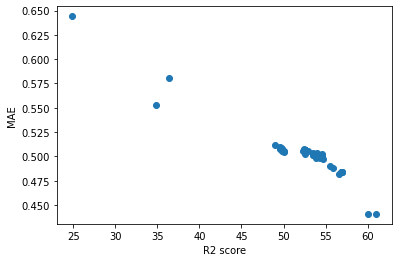

In [ ]:
plt.scatter(log_df['r2-score'], log_df['mae'])
plt.xlabel('R2 score')
plt.ylabel('MAE')

In [ ]:
# We are looking for model with higher kappa score and lower mae
log_df.sort_values(['cohen_kappa_score', 'r2-score', 'mae'], ascending=[False,False, True])

## **Training and Testing on Best Model** 

Different for each essay set

### **Training Best Model**

In [ ]:
y_col = "Total Score"
X = merged_df[['Sent_Count', 'Word_Count', 'Char_Count', 'Avg_Word_Count', 
               'Avg_Sentence_Length', 'Syllable_Count', 'Difficult_Word_Count', 
               'Verb_Count', 'Noun_Count', 'Adj_Count', 'Conj_Count', 'Adverb_Count', 
               'pNoun_Count', 'Spelling_Mistakes_Count', 'Count_Fullstops', 'Count_Exclamation', 
               'Count_Comma', 'Count_Questionmark', 'Count_Hyphens', 'Capitalization_Errors', 
               'Grammar_Error_Count', 'Semantic_Similarity', 'Connectivity_Index', 'Flesch_Reading_Ease_Score', 
               'Flesh_Kincaid_Grade', 'Dale_Challl_Readability_Score', 'Unique_Words_LD', 'Lexical_Diversity', 
               'Lexical_Density', 'Lexical_Originality', 'Lexical_Accuracy']]

y = merged_df[y_col]

data_logger = Logger_Regression("Lasso Regression", X.columns, len(X.columns))
data_logger.set_comment("Lasso Regression Model with SFS")
model = data_logger.lasso_regression(X,y,1,0.01)
model = model.fit(X,y)

Mean Absolute Error of Lasso Regression Model with SFS  0.485 
R2 score of Lasso Regression Model with SFS :57.076
Cohen Kappa score Lasso Regression Model with SFS : 0.676


In [ ]:
with open('model04.pkl', 'wb') as f:
  pickle.dump(model, f)

In [ ]:
files.download('/content/model04.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **Testing Best Model**

In [ ]:
# Testing set
df_test = pd.read_csv("/content/drive/MyDrive/IntelliTech-DataSet/Testing_Features_Set/EssaySet04_Testing_Features.csv", index_col =[0])
df_test.head()

,essay_id,essay_set,Essay,domain1_predictionid,predicted_score,domain2_predictionid,Sent_Count,Word_Count,Char_Count,Avg_Word_Count,...,Semantic_Similarity,Connectivity_Index,Flesch_Reading_Ease_Score,Flesh_Kincaid_Grade,Dale_Challl_Readability_Score,Unique_Words_LD,Lexical_Diversity,Lexical_Density,Lexical_Originality,Lexical_Accuracy
0,10643,4,"Moving from place to place, even in the same c...",13643,3,NaN,12,235,1074,3.706383,...,0.390581,23.008522,95.877917,3.592974,6.153238,87,0.370213,128,0.001347,7
1,10644,4,The author concludes the story with this parag...,13644,1,NaN,1,24,117,3.958333,...,0.000000,2.000000,80.250000,5.485517,8.116483,21,0.875000,14,0.000325,0
2,10645,4,"I guess since she failed the test once, she'll...",13645,2,NaN,3,122,545,3.614754,...,0.880204,17.045543,82.345219,12.006667,2.534772,33,0.270492,62,0.000511,3
3,10646,4,I believe that the author included the last pa...,13646,2,NaN,3,114,595,4.324561,...,0.508157,10.196271,59.175526,12.671020,7.737440,60,0.526316,66,0.000929,1
4,10647,4,The author concludes the story with Saeng’s pa...,13647,3,NaN,8,166,832,4.126506,...,0.282205,12.174348,76.201461,4.001948,8.090037,84,0.506024,90,0.001300,0


Extracting Word Embeddings 

In [ ]:
# create a list of essay strings
essays = df_test['Essay']
essay_list = [ess for ess in essays]

In [ ]:
# tokenize the string into words
tokens = [word_tokenize(ess) for ess in essay_list]

# Remove non-alphabetic tokens, such as punctuation
words_list = [[word.lower() for word in sentences if word.isalpha()] for sentences in tokens]

# Remove stopwords
words_list = [[word for word in sentence if not word in stop_words] for sentence in words_list]

In [ ]:
def word2vec_model(docs_list):
  model = Word2Vec(docs_list, min_count=1)

  # understanding the model
  # print("Dimension of Word Vectors are: ", model.vector_size)
  # word embedding vector for a specific token 'dear'
  #print(model.wv['dear'])

  vocab = list(model.wv.vocab.keys())
  df = pd.DataFrame([model.wv.word_vec(w) for w in vocab], index=vocab)
  print(df.shape)
  df.to_csv("word2vec_features.csv", index = True)
  return model

In [ ]:
model = word2vec_model(words_list)

(2690, 100)


In [ ]:
def document_vector(word2vec_model, doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc if word in model.wv.vocab]
    return np.mean(model[doc], axis=0)

# Our earlier preprocessing was done when we were dealing only with word vectors
# Here, we need each document to remain a document 
def preprocess(text):
    text = text.lower()
    doc = word_tokenize(text)
    doc = [word for word in doc if word not in stop_words]
    doc = [word for word in doc if word.isalpha()] 
    return doc

In [ ]:
corpus = [preprocess(essay) for essay in essay_list]
x = []
for doc in corpus: # append the vector for each document
    x.append(document_vector(model, doc))

<ipython-input-153-db7da09bea5a>:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  return np.mean(model[doc], axis=0)


In [ ]:
X = np.array(x)
df_d2v = pd.DataFrame(X)

In [ ]:
df_d2v.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.206838,-0.195971,0.251198,-0.146965,-0.117247,0.037354,-0.346350,0.260789,0.139781,-0.408942,...,-0.232818,0.430567,0.222980,-0.596547,-0.356311,-0.029327,0.192480,-0.119903,0.392795,0.422145
1,0.206415,-0.196307,0.253370,-0.147335,-0.117754,0.038443,-0.349279,0.260943,0.136487,-0.401628,...,-0.230408,0.430385,0.216094,-0.596169,-0.351254,-0.029987,0.192234,-0.125029,0.387219,0.417679
2,0.208360,-0.197587,0.252413,-0.145209,-0.121962,0.036649,-0.349446,0.257363,0.141844,-0.413185,...,-0.234773,0.438522,0.228691,-0.599800,-0.361767,-0.026987,0.193332,-0.121183,0.393945,0.426152
3,0.172720,-0.161169,0.208259,-0.124912,-0.096390,0.031198,-0.290421,0.221513,0.113424,-0.339447,...,-0.192868,0.355391,0.182975,-0.496072,-0.295712,-0.024444,0.159065,-0.102044,0.325878,0.348577
4,0.158108,-0.149594,0.192306,-0.112084,-0.089172,0.029250,-0.265055,0.200219,0.106323,-0.312134,...,-0.177502,0.328634,0.169806,-0.455981,-0.272169,-0.022860,0.146957,-0.092436,0.300681,0.321254


In [ ]:
df_test.head()

,essay_id,essay_set,Essay,domain1_predictionid,predicted_score,domain2_predictionid,Sent_Count,Word_Count,Char_Count,Avg_Word_Count,...,Semantic_Similarity,Connectivity_Index,Flesch_Reading_Ease_Score,Flesh_Kincaid_Grade,Dale_Challl_Readability_Score,Unique_Words_LD,Lexical_Diversity,Lexical_Density,Lexical_Originality,Lexical_Accuracy
0,10643,4,"Moving from place to place, even in the same c...",13643,3,NaN,12,235,1074,3.706383,...,0.390581,23.008522,95.877917,3.592974,6.153238,87,0.370213,128,0.001347,7
1,10644,4,The author concludes the story with this parag...,13644,1,NaN,1,24,117,3.958333,...,0.000000,2.000000,80.250000,5.485517,8.116483,21,0.875000,14,0.000325,0
2,10645,4,"I guess since she failed the test once, she'll...",13645,2,NaN,3,122,545,3.614754,...,0.880204,17.045543,82.345219,12.006667,2.534772,33,0.270492,62,0.000511,3
3,10646,4,I believe that the author included the last pa...,13646,2,NaN,3,114,595,4.324561,...,0.508157,10.196271,59.175526,12.671020,7.737440,60,0.526316,66,0.000929,1
4,10647,4,The author concludes the story with Saeng’s pa...,13647,3,NaN,8,166,832,4.126506,...,0.282205,12.174348,76.201461,4.001948,8.090037,84,0.506024,90,0.001300,0


In [ ]:
feats = ['Total Score', 'Sent_Count', 'Word_Count', 'Char_Count',
       'Avg_Word_Count', 'Avg_Sentence_Length', 'Syllable_Count', 'Difficult_Word_Count', 'Verb_Count', 'Noun_Count',
       'Adj_Count', 'Conj_Count', 'Adverb_Count', 'pNoun_Count',
       'Spelling_Mistakes_Count','Count_Fullstops', 'Count_Exclamation',
       'Count_Comma', 'Count_Questionmark', 'Count_Hyphens',
       'Capitalization_Errors', 'Grammar_Error_Count', 'Semantic_Similarity', 'Connectivity_Index',
       'Flesch_Reading_Ease_Score', 'Flesh_Kincaid_Grade',
       'Dale_Challl_Readability_Score', 'Unique_Words_LD', 'Lexical_Diversity',
       'Lexical_Density', 'Lexical_Originality', 'Lexical_Accuracy', 'predicted_score']
       
df_test = df_test.loc[:, df_test.columns.isin(feats)]

In [ ]:
df_test.head()

,predicted_score,Sent_Count,Word_Count,Char_Count,Avg_Word_Count,Avg_Sentence_Length,Syllable_Count,Difficult_Word_Count,Verb_Count,Noun_Count,...,Semantic_Similarity,Connectivity_Index,Flesch_Reading_Ease_Score,Flesh_Kincaid_Grade,Dale_Challl_Readability_Score,Unique_Words_LD,Lexical_Diversity,Lexical_Density,Lexical_Originality,Lexical_Accuracy
0,3,12,235,1074,3.706383,19.583333,253,23,32,37,...,0.390581,23.008522,95.877917,3.592974,6.153238,87,0.370213,128,0.001347,7
1,1,1,24,117,3.958333,24.000000,29,5,3,5,...,0.000000,2.000000,80.250000,5.485517,8.116483,21,0.875000,14,0.000325,0
2,2,3,122,545,3.614754,40.666667,120,4,17,16,...,0.880204,17.045543,82.345219,12.006667,2.534772,33,0.270492,62,0.000511,3
3,2,3,114,595,4.324561,38.000000,147,16,19,16,...,0.508157,10.196271,59.175526,12.671020,7.737440,60,0.526316,66,0.000929,1
4,3,8,166,832,4.126506,20.750000,215,36,18,31,...,0.282205,12.174348,76.201461,4.001948,8.090037,84,0.506024,90,0.001300,0


In [ ]:
merged_df_test = pd.concat([df_test,df_d2v], axis=1)
merged_df_test

,predicted_score,Sent_Count,Word_Count,Char_Count,Avg_Word_Count,Avg_Sentence_Length,Syllable_Count,Difficult_Word_Count,Verb_Count,Noun_Count,...,90,91,92,93,94,95,96,97,98,99
0,3,12,235,1074,3.706383,19.583333,253,23,32,37,...,-0.232818,0.430567,0.222980,-0.596547,-0.356311,-0.029327,0.192480,-0.119903,0.392795,0.422145
1,1,1,24,117,3.958333,24.000000,29,5,3,5,...,-0.230408,0.430385,0.216094,-0.596169,-0.351254,-0.029987,0.192234,-0.125029,0.387219,0.417679
2,2,3,122,545,3.614754,40.666667,120,4,17,16,...,-0.234773,0.438522,0.228691,-0.599800,-0.361767,-0.026987,0.193332,-0.121183,0.393945,0.426152
3,2,3,114,595,4.324561,38.000000,147,16,19,16,...,-0.192868,0.355391,0.182975,-0.496072,-0.295712,-0.024444,0.159065,-0.102044,0.325878,0.348577
4,3,8,166,832,4.126506,20.750000,215,36,18,31,...,-0.177502,0.328634,0.169806,-0.455981,-0.272169,-0.022860,0.146957,-0.092436,0.300681,0.321254
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581,3,10,239,1151,3.962343,23.900000,265,34,30,42,...,-0.169453,0.313731,0.161868,-0.434938,-0.259904,-0.021484,0.139982,-0.087379,0.286099,0.306570
582,0,1,71,353,3.985915,71.000000,84,8,14,13,...,-0.182999,0.341694,0.174117,-0.472961,-0.280290,-0.023548,0.152382,-0.096125,0.308946,0.331775
583,0,2,45,226,4.088889,22.500000,53,7,8,9,...,-0.239786,0.447376,0.229022,-0.614824,-0.366887,-0.029127,0.197290,-0.126721,0.403331,0.434097
584,2,3,145,699,3.937931,48.333333,168,21,22,24,...,-0.195731,0.363836,0.188782,-0.502140,-0.300416,-0.022260,0.161334,-0.101387,0.329601,0.355586


Filtering Features for Testing Data

In [ ]:
y_col = "predicted_score"
X = df_test[['Sent_Count', 'Word_Count', 'Char_Count', 'Avg_Word_Count', 'Avg_Sentence_Length', 
              'Syllable_Count', 'Difficult_Word_Count', 'Verb_Count', 'Noun_Count', 
              'Adj_Count', 'Conj_Count', 'Adverb_Count', 'pNoun_Count', 'Spelling_Mistakes_Count', 
              'Count_Fullstops', 'Count_Exclamation', 'Count_Comma', 'Count_Questionmark', 
              'Count_Hyphens', 'Capitalization_Errors', 'Grammar_Error_Count', 'Semantic_Similarity', 
              'Connectivity_Index', 'Flesch_Reading_Ease_Score', 'Flesh_Kincaid_Grade', 
              'Dale_Challl_Readability_Score', 'Unique_Words_LD', 'Lexical_Diversity', 'Lexical_Density', 
              'Lexical_Originality', 'Lexical_Accuracy']]

y = df_test[y_col]

In [ ]:
#Loading model from file
with open('model04.pkl', 'rb') as f:
  model = pickle.load(f)

In [ ]:
print(model.coef_)

[-0.         -0.00531048  0.00200033 -0.         -0.00194695  0.00114021
  0.01062532  0.00657877 -0.00769538  0.00980925  0.01562362 -0.01960179
 -0.00669685  0.          0.         -0.          0.00324189 -0.00726318
  0.          0.01258384 -0.01127782  0.         -0.00931266  0.00140158
 -0.         -0.          0.01741627 -0.         -0.          0.
 -0.00932671]


In [ ]:
#predicting results on test set
y_test_pred = model.predict(X)
y_test_pred = np.floor(y_test_pred)
r2_score_test = r2_score(y,y_test_pred)*100
mae_test = mean_absolute_error(y,y_test_pred)

print("Mean Absolute Error is  %.3f" %mae_test)
print("R2 score is : %.3f" %r2_score_test)
print("Cohen Kappa is: %.3f" %cohen_kappa_score(np.rint(y_test_pred), np.rint(y),weights="quadratic"))

Mean Absolute Error is  0.551
R2 score is : 19.202
Cohen Kappa is: 0.644


In [ ]:
df = pd.DataFrame({'Actual': y, 'Predicted': y_test_pred})

# Print the DataFrame as a string
print(df.to_string())

     Actual  Predicted
0         3        2.0
1         1        0.0
2         2        0.0
3         2        1.0
4         3        2.0
5         1        0.0
6         2        1.0
7         1        1.0
8         1        1.0
9         1        0.0
10        2        2.0
11        2        2.0
12        1        1.0
13        1        0.0
14        2        2.0
15        3        2.0
16        1        2.0
17        3        2.0
18        3        1.0
19        1        0.0
20        1        0.0
21        1        0.0
22        0        0.0
23        1        1.0
24        0        0.0
25        0        0.0
26        1        1.0
27        3        3.0
28        2        2.0
29        1        0.0
30        1        1.0
31        1        1.0
32        2        1.0
33        2        2.0
34        3        3.0
35        1        0.0
36        2        2.0
37        2        1.0
38        2        2.0
39        0        0.0
40        2        1.0
41        1        1.0
42        0